# Описание проекта
Контекст<br>
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

# Описание данных
<b>Данные для первой части:</b>

Файл <b>/datasets/hypothesis.csv</b>
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

<b>Данные для второй части:</b>

Файл <b>/datasets/orders.csv</b>
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл <b>/datasets/visitors.csv</b>
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и подготовка их к анализу

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

# Загрузка данных
hyp = pd.read_csv('datasets/hypothesis.csv')
orders = pd.read_csv('datasets/orders.csv')
visitors = pd.read_csv('datasets/visitors.csv')

# Увеличение ширины колонки
pd.options.display.max_colwidth = 120

In [2]:
#Смотрим общую информацию
for data in [hyp, orders, visitors]:
    display(data.head())
    print('Общая информация:')
    print(data.info())
    print()
    print('Количество пропуков:')
    print(round((data.isna().mean()*100),2))
    print()
    print('Количество дубликатов:', data.duplicated().sum())
    print()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

Количество пропуков:
Hypothesis    0.0
Reach         0.0
Impact        0.0
Confidence    0.0
Efforts       0.0
dtype: float64

Количество дубликатов: 0



,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

Количество пропуков:
transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

Количество дубликатов: 0



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

Количество пропуков:
date        0.0
group       0.0
visitors    0.0
dtype: float64

Количество дубликатов: 0



In [3]:
# Приведем названия столбцов к нижнему регистру
hyp.columns = hyp.columns.str.lower()
orders.columns = orders.columns.str.lower()

# Даты приведем к типу данных datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [4]:
# Смотрим корректность рапределения пользователей на группы
usersa = visitors[visitors['group'] == 'A']['visitors'].sum()
usersb = visitors[visitors['group'] == 'B']['visitors'].sum()
users = visitors['visitors'].sum()
print('Доля посетитеей группы А:', round(usersa/users*100, 2))
print('Доля посетитеей группы B:', round(usersb/users*100, 2))
   
# Проверка гипотезы о равенстве долей используя Z-критерий
alpha = 0.05 #критический уровень статистической значимости
_, pvalue = proportions_ztest(
    count=visitors.query("group=='A'")['visitors'].sum(), 
    nobs=visitors['visitors'].sum(),
    value=0.5
)
print('p-value = {0:.3f}'.format(pvalue))
if pvalue < alpha:
    print("Разница в количестве посетителей в группах A и B статистически значима")
else:
    print("Разница в количестве посетителей в группах A и B статистически НЕ значима")

Доля посетитеей группы А: 49.76
Доля посетитеей группы B: 50.24
p-value = 0.354
Разница в количестве посетителей в группах A и B статистически НЕ значима


In [5]:
# Проверка на пересечение пользователей
duplicatedusers = orders.groupby('visitorid').agg({'group':['nunique', 'unique']})
duplicatedusers.columns = ['groops_count', 'groop_names']
duplicatedusers = duplicatedusers[duplicatedusers['groops_count'] > 1]
display(duplicatedusers.head())
print('Количество пользователей попавших в обе группы:', len(duplicatedusers))

,groops_count,groop_names
visitorid,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"
232979603,2,"[B, A]"
237748145,2,"[B, A]"
276558944,2,"[B, A]"


Количество пользователей попавших в обе группы: 58


Дубликатов и пропусков не обнаружено. Группы тестирования разбиты корректно. 
Имеются 58 пользователей которые попали в обе группы тестирования. Эту информацию нужно передать разработчикам.

## Приоритизация гипотез

In [6]:
# Применим фраймворк ICE
hyp['ice'] = hyp['impact']*hyp['confidence']/hyp['efforts']
display(hyp[['hypothesis','ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

In [7]:
# Применим фраймворк RICE
hyp['rice'] = hyp['reach']*hyp['impact']*hyp['confidence']/hyp['efforts']
display(hyp[['hypothesis','rice', 'reach']].sort_values(by='rice', ascending=False))

,hypothesis,rice,reach
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,8
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,5
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,3


Наиболее перспективные гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

После применения фреймворка RISE вместо ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения" вылетела из перспективных. Это произошло потому, что охват пользователей, которых затронет изменение крайне мало. Как поется в известной песне "К сожаленью, день рожденья. Только раз в году."

## Анализ A/B-теста

### Кумулятивная выручка по группам

In [8]:
# Создаем массив дат и групп
datesgroups = orders[['date','group']].drop_duplicates()

# Соберем агрегированные кумулятивные данные
ordersagg = datesgroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
        'date' : 'max',
        'group' : 'max',
        'transactionid' : pd.Series.nunique,
        'visitorid' : pd.Series.nunique,
        'revenue' : 'sum'
    }), axis=1).sort_values(by=['date','group']) 

visitorsagg = datesgroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
        'date' : 'max',
        'group' : 'max',
        'visitors' : 'sum'
    }), axis=1).sort_values(by=['date','group'])

cumulativedata = ordersagg.merge(visitorsagg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativedata.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativedata.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


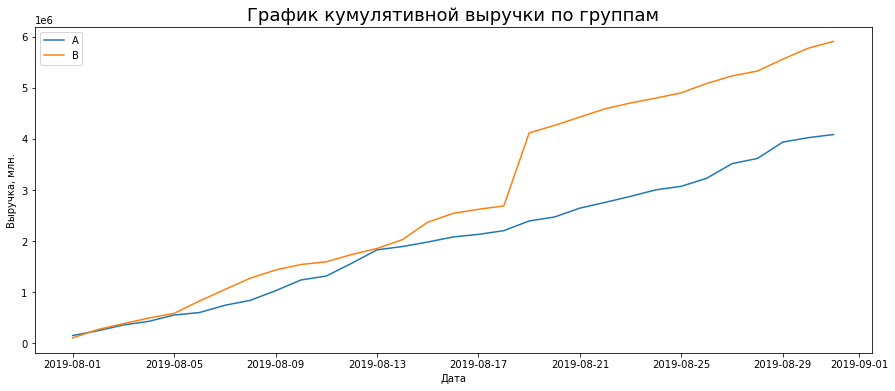

In [9]:
# Разбивка по группам
cumulativea = cumulativedata[cumulativedata['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeb = cumulativedata[cumulativedata['group'] == 'B'][['date', 'revenue', 'orders']]

# Строим график кумулятивной выручки
plt.figure(figsize=(15, 6))
plt.title('График кумулятивной выручки по группам', fontsize=18)
plt.plot(cumulativea['date'], cumulativea['revenue'], label = 'A')
plt.plot(cumulativeb['date'], cumulativeb['revenue'], label = 'B')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн.')
plt.legend()
plt.show()

Выручка равномерно увеличивалась до 18 августа 2019 в обоих группах, после группа B вырвалась вперед и лидировала весь остаток теста. Это может быть следствием аномально больших заказов или увеличения числа заказов. То,что выручка растет на протяжении всего теста - хороший знак.

### Кумулятивный средний чек по группам

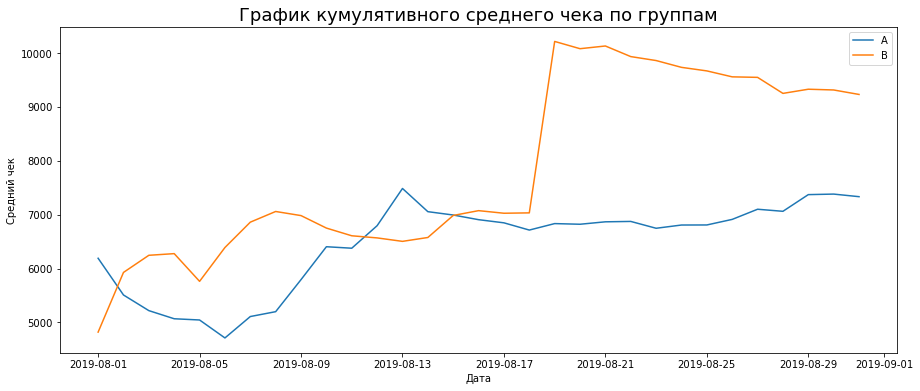

In [10]:
# Строим график кумулятивного среднего чека
plt.figure(figsize=(15, 6))
plt.title('График кумулятивного среднего чека по группам', fontsize=18)
plt.plot(cumulativea['date'], cumulativea['revenue']/cumulativea['orders'], label = 'A')
plt.plot(cumulativeb['date'], cumulativeb['revenue']/cumulativeb['orders'], label = 'B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.show()

Средний чек группы B так же резко вырос 19 августа 2019, как и в случае выручки. После чего наблюдается небольшое снижение. Средний чек группы A после 19 августа наоборот немного растет. Складывается ощущение, что средние чеки групп А и B хотят выровняться за горизонтом анализа в своеобразном треугольнике. 

Скорее всего, принимать решение по этой метрике рано. Или требуется дополнительный анализ выбросов.

### Относительное изменение кумулятивного среднего чека группы B к группе A

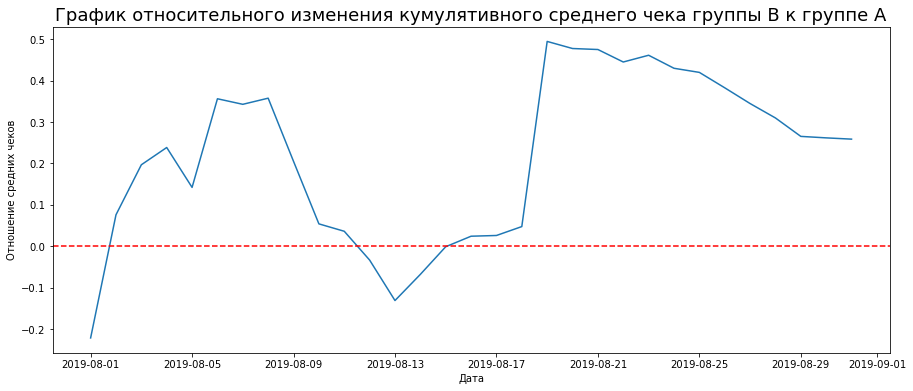

In [11]:
# Обьеденяем таблицы группы A и группы B
mergedcumulative = cumulativea.merge(
    cumulativeb, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# Строим график относительного изменения кумулятивного среднего чека
plt.figure(figsize=(15, 6))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=18)
plt.plot(
    mergedcumulative['date'],
    (mergedcumulative['revenue_b']/mergedcumulative['orders_b'])
    /(mergedcumulative['revenue_a']/mergedcumulative['orders_a'])
    -1
)
plt.axhline(y=0, color='red', linestyle='--') 
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков')
plt.show()

График резко "скачет" из-за аномальных заказов.

### Кумулятивная конверсия по группам

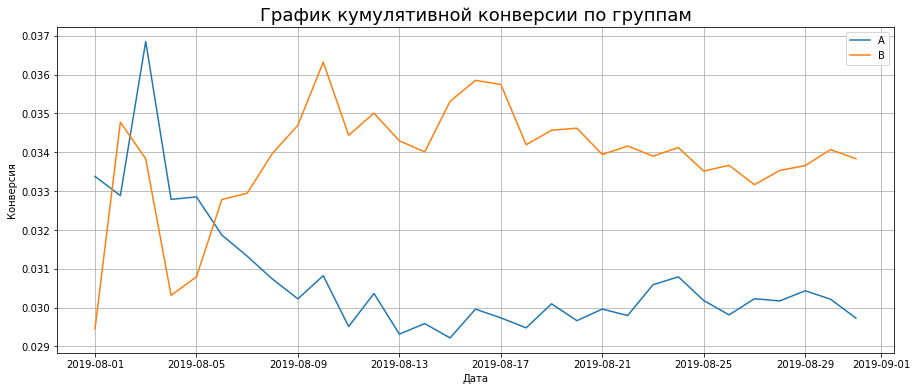

In [12]:
# Создадим столбец с конверсией
cumulativedata['conversion'] = cumulativedata['orders'] / cumulativedata['visitors']

# Разбивка по группам
cumulativea = cumulativedata[cumulativedata['group'] == 'A']
cumulativeb = cumulativedata[cumulativedata['group'] == 'B']

# Строим график кумулятивной конверсии
plt.figure(figsize=(15, 6))
plt.title('График кумулятивной конверсии по группам', fontsize=18)
plt.plot(cumulativea['date'], cumulativea['conversion'], label = 'A')
plt.plot(cumulativeb['date'], cumulativeb['conversion'], label = 'B')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()

Изначально конверсия группы А была больше конверсии группы B. Далее наблюдались "скачки" и резкое снижение конверсии по группе A и стабилизация в диапазоне 0.029-0.031, по группе B наоборот конверсия выросла и стабилизировалась в диапазоне 0.033-0.034.

### Относительное изменение кумулятивной конверсии группы B к группе A

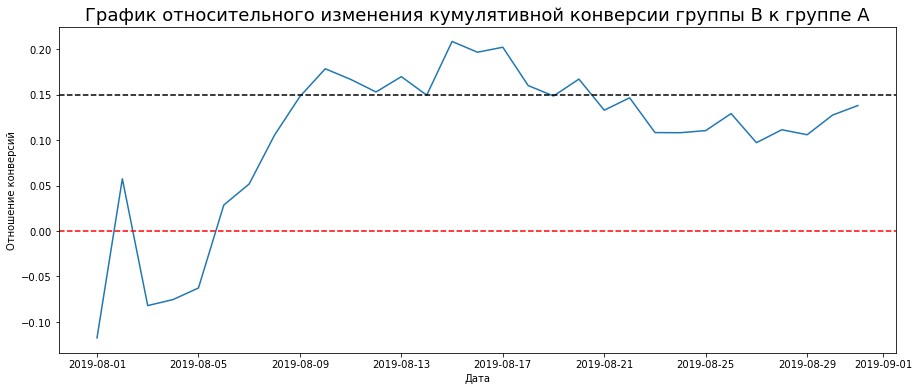

In [13]:
# Обьеденяем таблицы группы A и группы B
mergedcumulative = cumulativea.merge(
    cumulativeb, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# Строим график относительного изменения кумулятивного среднего чека
plt.figure(figsize=(15, 6))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=18)
plt.plot(
    mergedcumulative['date'],
    (mergedcumulative['conversion_b']/mergedcumulative['conversion_a'])
    -1
)
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.15, color='black', linestyle='--') 
plt.xlabel('Дата')
plt.ylabel('Отношение конверсий')
plt.show()

Практически с самого начала тестирования группа B вырвалась вперед группы A по конверсии и зафиксировалась около прироста в 15% относительно группы А.

### Количество заказов по пользователям

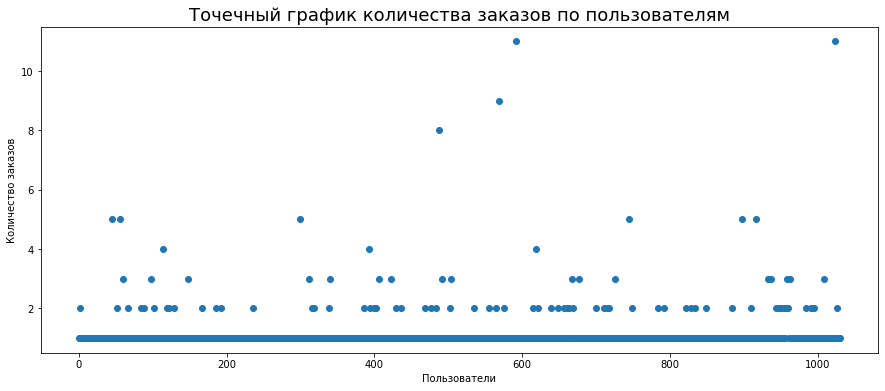

In [14]:
# Группировка заказов по пользователям
ordersbyusers = (orders.groupby('visitorid', as_index=False).agg({'transactionid': pd.Series.nunique}))

# Переименуем столбцы для удобства
ordersbyusers.columns = ['user_id', 'orders']

#Строим график
x_values = pd.Series(range(0,len(ordersbyusers)))
plt.figure(figsize=(15, 6))
plt.title('Точечный график количества заказов по пользователям', fontsize=18)
plt.scatter(x_values, ordersbyusers['orders']) 
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Пользователей заказавших более 3х раз очень мало. Они вполене могут быть аномальными.

In [15]:
#Расчет 95-й и 99-й перцентилей
print(np.percentile(ordersbyusers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей заказали более 2х заказов и не более 1% пользователей заказали более 4х заказов. Принимаем за аномальных пользователей, тех кто совершил больше 4х заказов, что соответствует 1% пользователей.

### Стоимость заказов

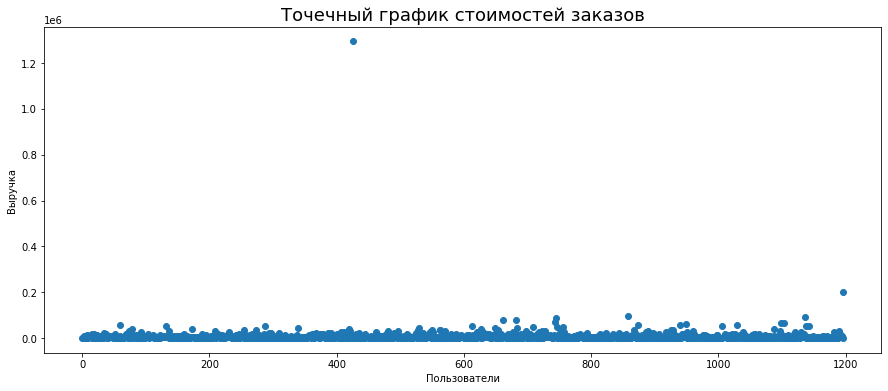

In [16]:
# Строим график
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 6))
plt.title('Точечный график стоимостей заказов', fontsize=18)
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Пользователи')
plt.ylabel('Выручка')
plt.show()

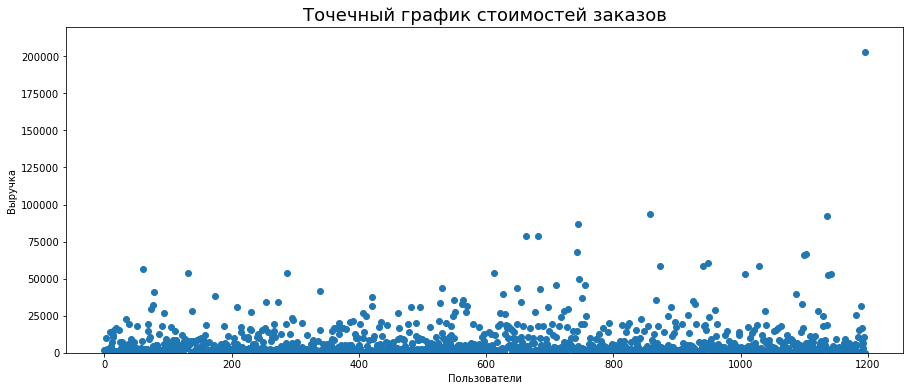

In [17]:
# В приближении
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 6))
plt.title('Точечный график стоимостей заказов', fontsize=18)
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Пользователи')
plt.ylabel('Выручка')
plt.ylim(0, 220000)
plt.show()

В отдалении мы видим два очень крупных заказа, которые явно являются выбросами. В приближении по графику аномальную границу стоимости заказов можно выбрать в диапазоне от 25000 до 50000.

In [18]:
#Расчет 95-й и 99-й перцентилей
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5 % заказов совершено на сумму 28000, не более 1 % - 58233.2. Примем за аномальные заказы, покупки на 50000 и более, что соответствует чуть больше 1% от количества заказов.

### Статистическая значимость различий в конверсии, в среднем чеке заказа между группами по «сырым» данным

In [19]:
# Соберем данные по заказам и визитам в одну таблицу
# Визиты
visitorsadaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsadaily.columns = ['date', 'visitorsperdatea']
 
visitorsacummulative = visitorsadaily.apply(
    lambda x: visitorsadaily[visitorsadaily['date'] <= x['date']].agg({
        'date' : 'max',
        'visitorsperdatea' : 'sum'
    }), axis=1)
visitorsacummulative.columns = ['date', 'visitorscummulativea']
 
visitorsbdaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsbdaily.columns = ['date', 'visitorsperdateb']
 
visitorsbcummulative = visitorsbdaily.apply(
    lambda x: visitorsbdaily[visitorsbdaily['date'] <= x['date']].agg({
        'date' : 'max',
        'visitorsperdateb' : 'sum'
    }), axis=1)
visitorsbcummulative.columns = ['date', 'visitorscummulativeb']

# Заказы
ordersadaily = (
    orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
)
ordersadaily.columns = ['date', 'ordersperdatea', 'revenueperdatea']
 
ordersacummulative = ordersadaily.apply(
    lambda x: ordersadaily[ordersadaily['date'] <= x['date']].agg({
        'date' : 'max',
        'ordersperdatea' : 'sum',
        'revenueperdatea' : 'sum'
    }), axis=1).sort_values(by=['date'])
ordersacummulative.columns = ['date', 'orderscummulativea', 'revenuecummulativea']
 
ordersbdaily = (
    orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
)
ordersbdaily.columns = ['date', 'ordersperdateb', 'revenueperdateb']
 
ordersbcummulative = ordersbdaily.apply(
    lambda x: ordersbdaily[ordersbdaily['date'] <= x['date']].agg({
        'date' : 'max',
        'ordersperdateb' : 'sum',
        'revenueperdateb' : 'sum'
    }), axis=1).sort_values(by=['date'])
ordersbcummulative.columns = ['date', 'orderscummulativeb', 'revenuecummulativeb']

# Объеденяем визиты и заказы в одну таблицу
data = ordersadaily.merge(ordersbdaily, left_on='date', right_on='date', how='left')\
    .merge(ordersacummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersbcummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsadaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsbdaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsacummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsbcummulative, left_on='date', right_on='date', how='left')
display(data.head())

,date,ordersperdatea,revenueperdatea,ordersperdateb,revenueperdateb,orderscummulativea,revenuecummulativea,orderscummulativeb,revenuecummulativeb,visitorsperdatea,visitorsperdateb,visitorscummulativea,visitorscummulativeb
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Воспользуемся критерием Манна-Уитни для подсчета статистической значимости различий в конверсии между группами<br><br>
<b>
H0: Конверсия группы A равна конверсии группы B<br>
H1: Конверсия группы A НЕ равна конверсии группы B<br>
</b>

In [20]:
# Подготовка данных к тесту Манна-Уитни
ordersbyusersa = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersbyusersa.columns = ['user_id', 'orders']

ordersbyusersb = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersbyusersb.columns = ['user_id', 'orders']
 
samplea = pd.concat(
    [
        ordersbyusersa['orders'],
        pd.Series(0, index=np.arange(data['visitorsperdatea'].sum() - len(ordersbyusersa['orders'])), name='orders')
    ],
    axis=0
)
sampleb = pd.concat(
    [
        ordersbyusersb['orders'],
        pd.Series(0, index=np.arange(data['visitorsperdateb'].sum() - len(ordersbyusersb['orders'])), name='orders')
    ],
    axis=0
)

# Статистическая значимость различий в конверсии
alpha = 0.05 #критический уровень статистической значимости
results = stats.mannwhitneyu(samplea, sampleb)
print('p-value = {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем H0: разница статистически значима')
else:
    print('Не получилось отвергнуть H0: вывод о различии сделать нельзя')
print('Относительный различие конверсии между группами "B" и "A" = {0:.3f}'.format(sampleb.mean()/samplea.mean()-1)) 

p-value = 0.017
Отвергаем H0: разница статистически значима
Относительный различие конверсии между группами "B" и "A" = 0.138


In [21]:
conversion = (orders
              .groupby('group')
              .agg({'transactionid':'count'})
              .rename(columns={'transactionid':'orders'})
             ).join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
#добавим столбец с конверсией
conversion['conversion'] = conversion['orders'] / conversion['visitors']
display(conversion)

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


P-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем. Конверсия группы B на 13.8% больше конверсии группы А.

Воспользуемся критерием Манна-Уитни для подсчета статистической значимости различий в среднем чеке заказа между группами<br>
<b>
H0: Средний чек A равен среднему чеку группы B<br>
H1: Средний чек A НЕ равен среднему чеку группы B<br>
</b>

In [22]:
# Статистическая значимость различий в среднем чеке заказа
alpha = 0.05 #критический уровень статистической значимости
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('p-value = {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем H0: разница статистически значима')
else:
    print('Не получилось отвергнуть H0: вывод о различии сделать нельзя')
print(
    'Относительный различие среднего чека заказа между группами "B" и "A" = {0:.3f}'
    .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)
)

p-value = 0.729
Не получилось отвергнуть H0: вывод о различии сделать нельзя
Относительный различие среднего чека заказа между группами "B" и "A" = 0.259


In [23]:
print('Средний чек группы А:', round(orders[orders['group']=='A']['revenue'].mean(), 2))
print('Средний чек группы B:', round(orders[orders['group']=='B']['revenue'].mean(), 2))

Средний чек группы А: 7333.58
Средний чек группы B: 9230.88


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B на 25,9% больше среднего чека группы A.

### Cтатистическая значимость различий в конверсии, в среднем чеке заказа между группами по «очищенным» данным

In [24]:
#  Очистка данных от аномалий
userswithmanyorders = pd.concat(
    [
        ordersbyusersa[ordersbyusersa['orders'] > 4]['user_id'],
        ordersbyusersb[ordersbyusersb['orders'] > 4]['user_id'],
    ],
    axis=0,
)
userswithexpensiveorders = orders[orders['revenue'] > 50000]['visitorid']

anomalusers = (
    pd.concat([userswithmanyorders, userswithexpensiveorders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(anomalusers.head())
print(anomalusers.shape)

1099     148427295
1137     759473111
949      887908475
744      888512513
1103    1164614297
dtype: int64
(21,)


Всего обнаружен 21 аномальный пользователь

Воспользуемся критерием Манна-Уитни для подсчета статистической значимости различий в конверсии между группами<br><br>
<b>
H0: Конверсия группы A равна конверсии группы B<br>
H1: Конверсия группы A НЕ равна конверсии группы B<br>
</b>

In [25]:
# Подготовка выборок теста по очищенным данным
sampleafiltered = pd.concat(
    [
        ordersbyusersa[np.logical_not(ordersbyusersa['user_id'].isin(anomalusers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsperdatea'].sum() - len(ordersbyusersa['orders'])), name='orders')
    ],
    axis=0,
)

samplebfiltered = pd.concat(
    [
        ordersbyusersb[np.logical_not(ordersbyusersb['user_id'].isin(anomalusers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsperdateb'].sum() - len(ordersbyusersb['orders'])), name='orders')
    ],
    axis=0,
) 

# Статистическая значимость различий в конверсии
alpha = 0.05 #критический уровень статистической значимости
results = stats.mannwhitneyu(sampleafiltered, samplebfiltered)
print('p-value = {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем H0: разница статистически значима')
else:
    print('Не получилось отвергнуть H0: вывод о различии сделать нельзя')
print(
    'Относительный различие конверсии между группами "B" и "A" = {0:.3f}'
    .format(samplebfiltered.mean()/sampleafiltered.mean()-1)
) 

p-value = 0.012
Отвергаем H0: разница статистически значима
Относительный различие конверсии между группами "B" и "A" = 0.160


In [26]:
orders_clear = orders[~orders['visitorid'].isin(anomalusers)]
conversion_clear = (orders_clear
                    .groupby('group')
                    .agg({'transactionid':'count'})
                    .rename(columns={'transactionid':'orders'})
                   ).join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion_clear['conversion'] = conversion_clear['orders'] / conversion_clear['visitors']
display(conversion_clear)

,group,orders,visitors,conversion
0,A,524,18736,0.027968
1,B,614,18916,0.032459


По очищенным данным p-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет - отвергаем. Конверсия группы B на 16% больше конверсии группы А.

Воспользуемся критерием Манна-Уитни для подсчета статистической значимости различий в среднем чеке заказа между группами<br>
<b>
H0: Средний чек A равен среднему чеку группы B<br>
H1: Средний чек A НЕ равен среднему чеку группы B<br>
</b>

In [27]:
# Статистическая значимость различий в среднем чеке заказа
alpha = 0.05 #критический уровень статистической значимости
results = stats.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(anomalusers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(anomalusers)))]['revenue']
        )
print('p-value = {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем H0: разница статистически значима')
else:
    print('Не получилось отвергнуть H0: вывод о различии сделать нельзя')
print(
    'Относительный различие среднего чека заказа между группами "B" и "A" = {0:.3f}'
    .format(
        orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(anomalusers)))]['revenue'].mean()
        /orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(anomalusers)))]['revenue'].mean()
        -1
    )
)


p-value = 0.715
Не получилось отвергнуть H0: вывод о различии сделать нельзя
Относительный различие среднего чека заказа между группами "B" и "A" = 0.032


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B всего на 3,2% больше среднего чека группы A.

In [28]:
print('Среднее значение чека в группе А:', round(orders_clear[orders_clear['group']=='A']['revenue'].mean(), 2))
print('Среднее значение чека в группе B:', round(orders_clear[orders_clear['group']=='B']['revenue'].mean(), 2))

Среднее значение чека в группе А: 6054.13
Среднее значение чека в группе B: 6246.71


### Принятие решения по результатам A/B теста

На мой взгляд верным решением будет закончить тест, признать его успешным и зафиксировать победу группы B.

Куммулятивные метрики по выручке, конверсии и среднему чеку практически на всем этапе тестирования были больше у группы B. Были сомнения из-за резких колебаний на графике кумулятивного среднего чека в группе B до очистки данных от аномальных пользователей. После очистки разница между средними чеками и вправду стала минимальна, но это не меняет выводы о результатах теста ведь до и после очистки данных показатель конверсии в группе B больше показателя в группе A (на 13,8% и 16% сооветственно). Данная разница конверсии между группами А и B является статистически значимой.
Также фактором для завершения теста является время, отведенное для проведения теста. Бизнес не может ждать любое требуемое время, а тест уже длился 30 дней.